In [1]:
import polars as pl
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
import numpy as np

In [2]:
# Y_CNN is of shape (n, 10) representing 10 classes as 10 columns. In each sample, for the class to which it belongs, 
# the corresponding column value is marked 1 and the rest as 0, facilitating Softmax implementation in CNN 
# Y is of shape (m, 1) where column values are between 0 and 9 representing the classes directly. - 1-hot encoding
vibration_data = pl.read_csv(r'./vibration_data.csv').to_numpy()
X = vibration_data[1:, :].T
Y = vibration_data[0, :]

print("Vibration dataset shape:", vibration_data.shape)
print("Shape of Input Data:", X.shape)
print("Shape of Label Y:", Y.shape)

Vibration dataset shape: (93753, 1158)
Shape of Input Data: (1158, 93752)
Shape of Label Y: (1158,)


In [3]:
kSplits = 5
kfold = KFold(n_splits=kSplits, random_state=32, shuffle=True)

In [4]:
Input_1D = X.reshape([-1, X.shape[1], 1])

# Test-Train Split 
X_1D_train, X_1D_test, y_1D_train, y_1D_test = train_test_split(Input_1D, Y, train_size=0.75,test_size=0.25, random_state=101)

# Define the CNN Classification model
class CNN_1D():
  def __init__(self):
    self.model = self.CreateModel()

  def CreateModel(self):
    model = models.Sequential([
        layers.Conv1D(filters=16, kernel_size=3, strides=2, activation='relu', input_shape=(X.shape[1], 1)),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=32, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=64, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Conv1D(filters=128, kernel_size=3, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    return model


accuracy_1D = []

# Train the model 
for train, test in kfold.split(X_1D_train,y_1D_train):
  Classification_1D = CNN_1D()
  history = Classification_1D.model.fit(X_1D_train[train], y_1D_train[train], verbose=1, epochs=12, validation_split=0.2)

  # Evaluate the accuracy of the model on the training set 
  kf_loss, kf_accuracy = Classification_1D.model.evaluate(X_1D_train[test], y_1D_train[test]) 
  accuracy_1D.append(kf_accuracy)

CNN_1D_train_accuracy = np.average(accuracy_1D)*100
print('CNN 1D train accuracy =', CNN_1D_train_accuracy)


# Evaluate the accuracy of the model on the test set
CNN_1D_test_loss, CNN_1D_test_accuracy = Classification_1D.model.evaluate(X_1D_test, y_1D_test)
CNN_1D_test_accuracy*=100
print('CNN 1D test accuracy =', CNN_1D_test_accuracy)

d:\Anaconda\envs\my-course\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - accuracy: 0.6013 - loss: 1.4817 - val_accuracy: 0.6835 - val_loss: 0.6035
Epoch 2/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - accuracy: 0.7769 - loss: 0.4695 - val_accuracy: 0.6906 - val_loss: 0.3224
Epoch 3/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - accuracy: 0.9357 - loss: 0.2007 - val_accuracy: 0.9928 - val_loss: 0.0407
Epoch 4/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - accuracy: 0.9979 - loss: 0.0260 - val_accuracy: 0.9928 - val_loss: 0.0266
Epoch 5/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - accuracy: 0.9993 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 6/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 447ms/step - accuracy: 0.9972 - loss: 0.0082 - val_accuracy: 0.9928 - val_loss: 0.0176
Epoch 7/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9928 - val_loss: 0.0088
Epoch 8/12
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - accuracy: 1.0000 - loss: 2.4893e-04 - val_accurac

In [5]:
X_reshaped = X.reshape(-1, X.shape[1], 1)

# Predict labels using the trained model
predicted_labels = Classification_1D.model.predict(X_reshaped).flatten()
predicted_labels = np.round(predicted_labels).astype(int)  # Convert probabilities to binary (0 or 1)

# Create a comparison array with predictions and actual labels
comparison = np.vstack((predicted_labels, Y))
print("Comparison of identifiers, predicted labels, and actual answers:")
print(comparison)
df_res = pl.DataFrame({
    "Predicted Labels": comparison[0,:].astype(int),
    "Actual Answers": comparison[1,:].astype(int)
})
df_res.write_csv("results_cnn.csv")
df_res.describe()
accuracy = np.mean(predicted_labels == Y)
print(f"Accuracy of the autoencoder predictions: {accuracy:.3f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step
Comparison of identifiers, predicted labels, and actual answers:
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Accuracy of the autoencoder predictions: 0.998


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step 
Comparison of identifiers, predicted labels, and actual answers:
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Accuracy of the autoencoder predictions: 0.998
[Summary Statistics]
Accuracy = 99.83% | Precision = 99.32% | Recall = 100.00% | Specificity = 99.77% | F1 Score = 99.66%


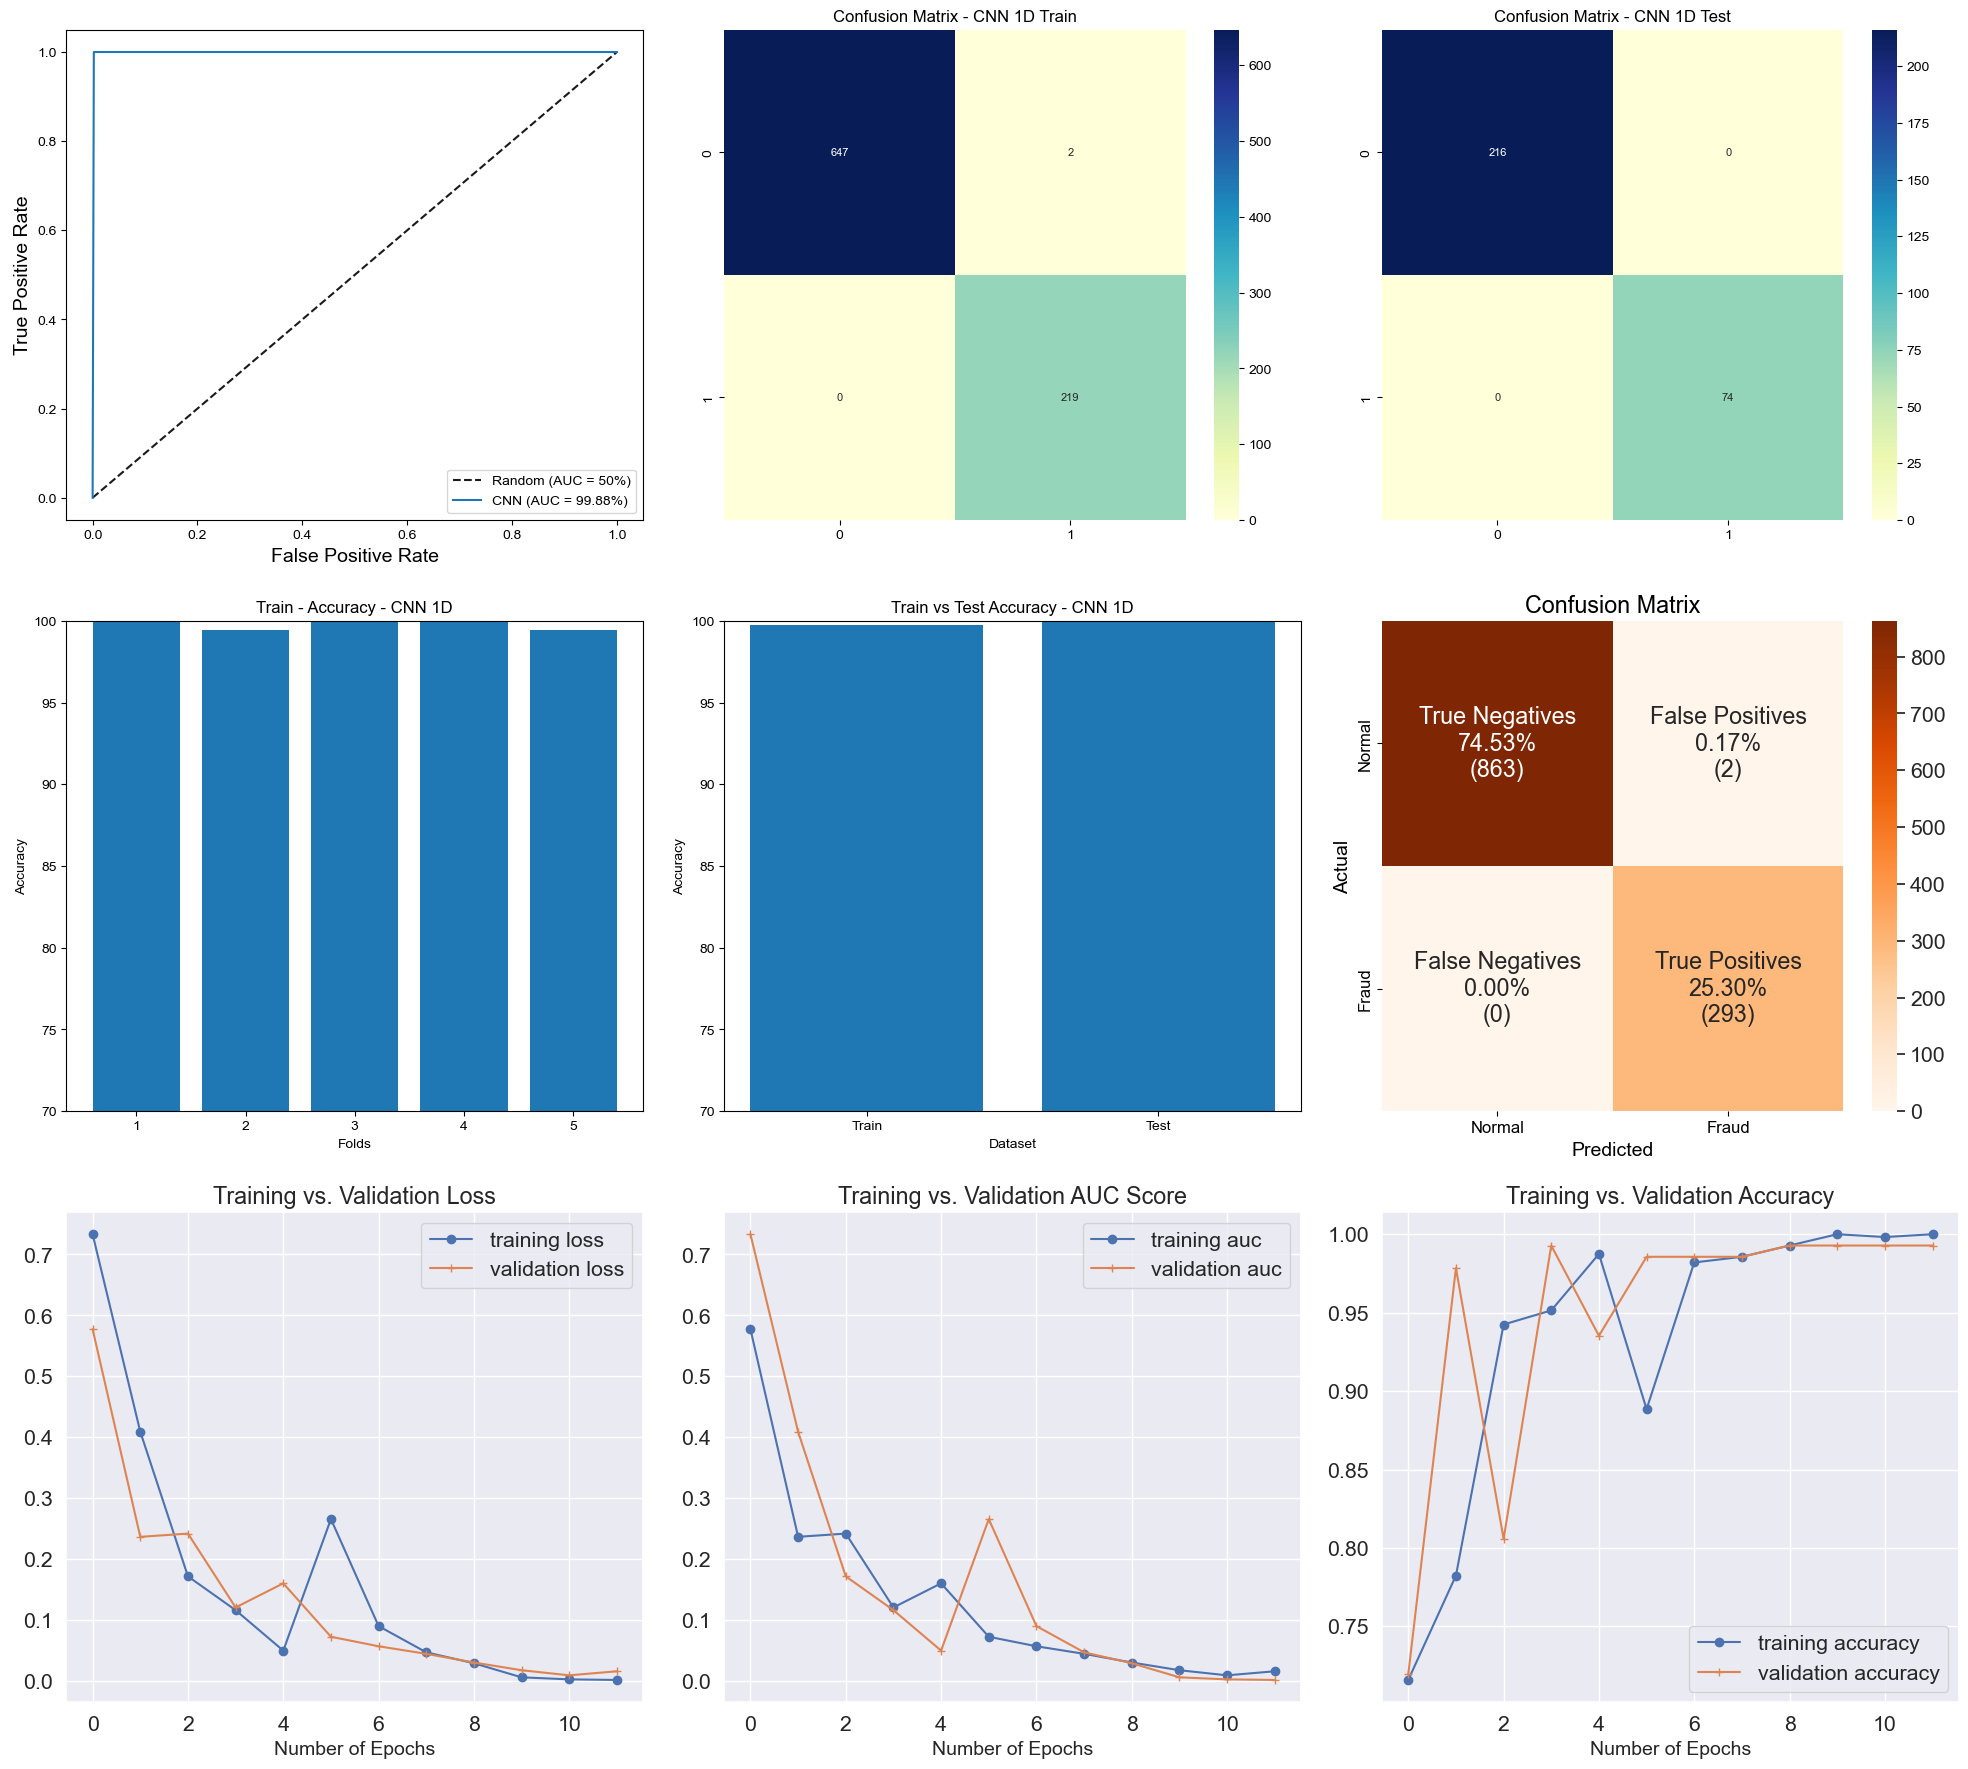

In [6]:
def ConfusionMatrix(Model, X, y):
    y_pred = np.round(Model.model.predict(X)).astype(int).flatten()  
    ConfusionMat = confusion_matrix(y, y_pred)  
    return ConfusionMat

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Define train & validation AUC
train_auc_name = list(history.history.keys())[3]
val_auc_name = list(history.history.keys())[1]
train_auc = history.history[train_auc_name]
val_auc = history.history[val_auc_name]
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

true_labels = Y.flatten()

auc_score = roc_auc_score(true_labels, predicted_labels)

# Plot
plt.figure(figsize=(20, 18))
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

# Plot 1:  ROC curve
plt.subplot(3, 3, 1)
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc_score * 100))
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend(loc='best')

# Plot the confusion matrix for training data
plt.subplot(3, 3, 2)
plt.title('Confusion Matrix - CNN 1D Train')
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_train, y_1D_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")

# Plot the confusion matrix for test data
plt.subplot(3, 3, 3)
plt.title('Confusion Matrix - CNN 1D Test')
sns.heatmap(ConfusionMatrix(Classification_1D, X_1D_test, y_1D_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")

# Accuracy for each fold (Training accuracy plot)
plt.subplot(3, 3, 4)
plt.title('Train - Accuracy - CNN 1D')
plt.bar(np.arange(1, kSplits + 1), [i * 100 for i in accuracy_1D])
plt.ylabel('Accuracy')
plt.xlabel('Folds')
plt.ylim([70, 100])

# Train vs Test accuracy comparison
plt.subplot(3, 3, 5)
plt.title('Train vs Test Accuracy - CNN 1D')
plt.bar([1, 2], [CNN_1D_train_accuracy, CNN_1D_test_accuracy])
plt.ylabel('Accuracy')
plt.xlabel('Dataset')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([70, 100])

# Plot 6: Heatmap
plt.subplot(3, 3, 6)
cm = confusion_matrix(true_labels, predicted_labels)
names = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
counts = [value for value in cm.flatten()]
labels = [f'{v1}\n{v2}\n({v3})' for v1, v2, v3 in zip(names, percentages, counts)]
labels = np.asarray(labels).reshape(2, 2)
ticklabels = ['Normal', 'Fraud']

# Create confusion matrix as heatmap
sns.set(font_scale=1.4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Oranges', xticklabels=ticklabels, yticklabels=ticklabels)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title("Confusion Matrix")
plt.xlabel("Predicted", size=14)
plt.ylabel("Actual", size=14)

# Plot 7: Train vs. Validation Loss 
plt.subplot(3, 3, 7)
plt.title("Training vs. Validation Loss")
plt.plot(train_loss, label='training loss', marker='o')
plt.plot(val_loss, label='validation loss', marker='+')
plt.xlabel("Number of Epochs", size=14)
plt.legend()

# Plot 8: Train vs. Validation AUC
plt.subplot(3, 3, 8)
plt.title("Training vs. Validation AUC Score")
plt.plot(train_auc, label='training auc', marker='o')
plt.plot(val_auc, label='validation auc', marker='+')
plt.xlabel("Number of Epochs", size=14)
plt.legend()

## PLOT 9: TRAIN VS. VALIDATION ACCURACY
plt.subplot(3,3,9)
plt.title("Training vs. Validation Accuracy")
plt.plot(train_acc, label='training accuracy', marker='o')
plt.plot(val_acc, label='validation accuracy', marker='+')
plt.xlabel("Number of Epochs", size=14)
plt.legend()

# End plots
plt.tight_layout()

# Accuracy
comparison = np.vstack((predicted_labels, true_labels))

print("Comparison of identifiers, predicted labels, and actual answers:")
print(comparison)

accuracy = np.mean(predicted_labels == true_labels)
print(f"Accuracy of the autoencoder predictions: {accuracy:.3f}")

# Summary Statistics
TN, FP, FN, TP = cm.ravel()
accuracy = (TP + TN) / np.sum(cm)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)
f1 = 2 * precision * recall / (precision + recall)
stats_summary = '[Summary Statistics]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specificity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specificity, f1)
print(stats_summary)